In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
import seaborn as sb
import torch
import torch.nn as nn
import torch.optim as optim
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import random
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score, make_scorer


In [2]:
# Fix random state for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False

        
set_random_seed(4)

# Data observation

## CSV Data

In [3]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

In [4]:
df_train = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
df_test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
df_data_dict = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv")

In [5]:
print(f"Features size (Test): {len(df_test.columns)}")
print(f"Features size (Train): {len(df_train.columns)}")
print('-' * 20)
print(f"{'Features':<100}{'Test':<10}{'Train':<10}")
for i in range(len(df_train.columns) - 1):
    test_column_status = "Yes" if (df_train.columns[i] in df_test.columns) else "---"
    train_column_status = "Yes"
    attribute = f"{df_train.columns[i]}"
    print(f"{attribute:<100}{test_column_status:<10}{train_column_status:<10}")

Features size (Test): 59
Features size (Train): 82
--------------------
Features                                                                                            Test      Train     
id                                                                                                  Yes       Yes       
Basic_Demos-Enroll_Season                                                                           Yes       Yes       
Basic_Demos-Age                                                                                     Yes       Yes       
Basic_Demos-Sex                                                                                     Yes       Yes       
CGAS-Season                                                                                         Yes       Yes       
CGAS-CGAS_Score                                                                                     Yes       Yes       
Physical-Season                                                                  

In [6]:
unlabeled = df_train['sii'].isna().sum()
print(f"Unlabeled Data / Total = {unlabeled} / {len(df_train['sii'])}")

Unlabeled Data / Total = 1224 / 3960


In [7]:
# label distribution
df_train['sii'].value_counts()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

## Parquet Data

In [8]:
ts_df = pd.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=01085eb3', engine='pyarrow')

In [9]:
ts_df.describe()

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
count,370956.000000,370956.000000,370956.000000,370956.000000,370956.000000,370956.000000,370956.000000,370956.000000,370956.000000,3.709560e+05,370956.000000,370956.0,370956.000000
mean,185477.500000,-0.343396,-0.055826,-0.254433,0.032946,-17.589041,0.035210,17.800735,3849.649414,4.338433e+13,3.963284,4.0,49.910686
std,107085.917566,0.516126,0.424303,0.564593,0.083798,39.895645,0.183652,73.023468,171.100159,2.513356e+13,1.994539,0.0,6.204418
min,0.000000,-2.284304,-2.276082,-1.022549,0.000000,-89.877220,0.000000,0.000000,3098.166748,0.000000e+00,1.000000,4.0,39.000000
25%,92738.750000,-0.784639,-0.312203,-0.753955,0.001059,-49.667419,0.000000,2.500000,3740.833252,2.147500e+13,2.000000,4.0,45.000000
50%,185477.500000,-0.473294,-0.018973,-0.354672,0.008127,-21.538264,0.000000,6.677332,3827.833252,4.355500e+13,4.000000,4.0,50.000000
75%,278216.250000,0.068885,0.206397,0.113704,0.026206,6.416064,0.000000,17.742268,3982.000000,6.532000e+13,6.000000,4.0,55.000000
max,370955.000000,1.000692,1.011419,1.299293,4.097965,88.478432,1.000000,2650.500000,4184.000000,8.639500e+13,7.000000,4.0,61.000000


Text(0, 0.5, 'X')

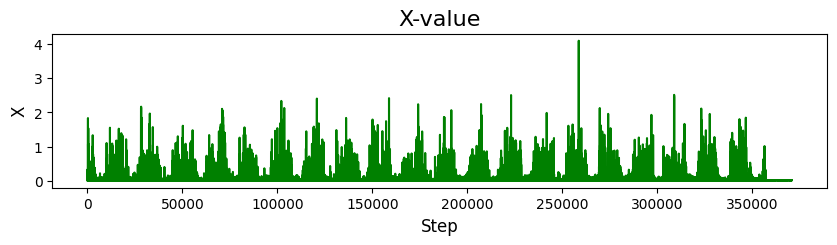

In [10]:
plt.figure(figsize=(10, 2)) 
plt.plot(ts_df['step'], ts_df['enmo'], color='g')
plt.title('X-value', fontsize=16)
plt.xlabel('Step', fontsize=12)
plt.ylabel('X', fontsize=12)

# Data Processing

In [11]:
is_aggregated = True
is_derived = True
is_removed_weak_correlation = False
weak_correlation_threshold = 0.07
dropped_columns = ['id', 'SDS-SDS_Total_T']

## CSV

In [12]:
df_train = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
df_test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
df_data_dict = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv")

In [13]:
# Remove unlabeled data
# df_train = df_train.dropna(subset=['sii'])

# Drop columns > 60% Nan
reliable_columns = df_train.columns[df_train.isna().mean() < 0.6]
df_train = df_train[reliable_columns]

In [14]:
season_cols = [
    'Basic_Demos-Enroll_Season',
    'CGAS-Season', 
    'Physical-Season',
    'Fitness_Endurance-Season',
    'FGC-Season',
    'BIA-Season',
    'PAQ_A-Season', 
    'PAQ_C-Season',
    'PCIAT-Season', 
    'SDS-Season',
    'PreInt_EduHx-Season',
]
# Create a mapping dictionary for seasons
season_mapping = {
    'Spring': 0,
    'Summer': 1,
    'Fall': 2,
    'Winter': 3
}

# Apply manual encoding to the categorical columns
def seasonMapping(dataframe):
    pd.set_option('future.no_silent_downcasting', True)
    for col in season_cols:
        if col in dataframe.columns:
            dataframe[col] = dataframe[col].replace(season_mapping)
            dataframe[col] = dataframe[col].astype(int)

def seasonRemoving(dataframe):
    season_cols = [col for col in dataframe.columns if 'Season' in col]
    dataframe = dataframe.drop(season_cols, axis=1)
    return dataframe

In [15]:
def derived_attributes(df):
    # season_cols = [col for col in df.columns if 'Season' in col]
    # df = df.drop(season_cols, axis=1) 
    df['Pulse_Pressure__'] = df['Physical-Systolic_BP'] - df['Physical-Diastolic_BP']
    df['Fat_Muscle_Ratio__'] = df['BIA-BIA_Fat'] / df['BIA-BIA_LDM']
    df['Weight_Height_Ratio__'] = df['Physical-Weight'] / df['Physical-Height']
    df['Physical_Sleep_Disturbance__'] = df['PAQ_C-PAQ_C_Total'] * df['SDS-SDS_Total_Raw']    
    
    #Age
    df['Internet_Hours_Age__'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Age__'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Physical-Height_Age__'] = df['Basic_Demos-Age'] * df['Physical-Height']
    df['SDS_InternetHours__'] = df['SDS-SDS_Total_T'] * df['PreInt_EduHx-computerinternet_hoursday']

    #SDS
    df['SDS_Activity__'] = df['BIA-BIA_Activity_Level_num'] * df['SDS-SDS_Total_T']

    df['BMI_Systolic_BP__'] = df['BIA-BIA_BMI'] * df['Physical-Systolic_BP']
    df['Age_Systolic_BP__'] = df['Basic_Demos-Age'] * df['Physical-Systolic_BP']
    df['PreInt_Systolic_BP__'] = df['Physical-Systolic_BP'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['Activity_CU_PU__'] = df['BIA-BIA_Activity_Level_num'] * df['FGC-FGC_CU'] * df['FGC-FGC_PU']

    #FGC
    df['FGC_CU_PU__'] = df['FGC-FGC_CU'] * df['FGC-FGC_PU']
    df['FGC_CU_PU_Age__'] = df['FGC-FGC_CU'] * df['FGC-FGC_PU'] * df['Basic_Demos-Age']
    df['CGAS_CU_PU__'] = df['CGAS-CGAS_Score'] * df['FGC-FGC_CU'] * df['FGC-FGC_PU']
    df['PreInt_FGC_CU_PU__'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['FGC-FGC_CU'] * df['FGC-FGC_PU']

    return df

In [16]:
df_train = seasonRemoving(df_train)

In [17]:
# Get the common columns with test
common_columns = df_train.columns.intersection(df_test.columns)
df_train_no_label = df_train[common_columns].copy()
df_train_no_label['sii'] = df_train['sii']

df_train = df_train_no_label   # with label now
df_test = df_test[common_columns].copy()

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 41 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Age                         3960 non-null   int64  
 2   Basic_Demos-Sex                         3960 non-null   int64  
 3   CGAS-CGAS_Score                         2421 non-null   float64
 4   Physical-BMI                            3022 non-null   float64
 5   Physical-Height                         3027 non-null   float64
 6   Physical-Weight                         3076 non-null   float64
 7   Physical-Diastolic_BP                   2954 non-null   float64
 8   Physical-HeartRate                      2967 non-null   float64
 9   Physical-Systolic_BP                    2954 non-null   float64
 10  FGC-FGC_CU                              2322 non-null   floa

In [19]:
imputer = KNNImputer(n_neighbors=5)
numeric_cols_train = df_train.select_dtypes(include=['int32', 'int64', 'float64']).columns
numeric_cols_test = df_test.select_dtypes(include=['int32', 'int64', 'float64']).columns

imputed_data_train = imputer.fit_transform(df_train[numeric_cols_train])
imputed_data_test = imputer.fit_transform(df_test[numeric_cols_test])

df_train_no_id = pd.DataFrame(imputed_data_train, columns=numeric_cols_train, index=df_train.index)
df_test_no_id = pd.DataFrame(imputed_data_test, columns=numeric_cols_test, index=df_test.index)

df_train_no_id['id'] = df_train['id']
df_test_no_id['id'] = df_test['id']

df_train = df_train_no_id
df_test = df_test_no_id
df_train['sii'] = df_train['sii'].round().astype(int)


In [20]:
if is_derived:
    derived_attributes(df_train)
    derived_attributes(df_test)

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 58 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Age                         3960 non-null   float64
 1   Basic_Demos-Sex                         3960 non-null   float64
 2   CGAS-CGAS_Score                         3960 non-null   float64
 3   Physical-BMI                            3960 non-null   float64
 4   Physical-Height                         3960 non-null   float64
 5   Physical-Weight                         3960 non-null   float64
 6   Physical-Diastolic_BP                   3960 non-null   float64
 7   Physical-HeartRate                      3960 non-null   float64
 8   Physical-Systolic_BP                    3960 non-null   float64
 9   FGC-FGC_CU                              3960 non-null   float64
 10  FGC-FGC_CU_Zone                         3960 non-null   floa

In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Age                         20 non-null     float64
 1   Basic_Demos-Sex                         20 non-null     float64
 2   CGAS-CGAS_Score                         20 non-null     float64
 3   Physical-BMI                            20 non-null     float64
 4   Physical-Height                         20 non-null     float64
 5   Physical-Weight                         20 non-null     float64
 6   Physical-Diastolic_BP                   20 non-null     float64
 7   Physical-HeartRate                      20 non-null     float64
 8   Physical-Systolic_BP                    20 non-null     float64
 9   FGC-FGC_CU                              20 non-null     float64
 10  FGC-FGC_CU_Zone                         20 non-null     float64


## Parquet

In [23]:
train_parquet_dir = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/'
test_parquet_dir = '/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/'

In [24]:
class EncoderDecoderModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EncoderDecoderModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, output_dim*3),
            nn.ReLU(),
            nn.Linear(output_dim*3, output_dim*2),
            nn.ReLU(),
            nn.Linear(output_dim*2, output_dim),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(output_dim, output_dim*2),
            nn.ReLU(),
            nn.Linear(output_dim*2, output_dim*3),
            nn.ReLU(),
            nn.Linear(output_dim*3, input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))
        

In [25]:
def process_file(dirname, filename):
    # print(os.path.join(dirname, filename, 'part-0.parquet'))
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname):
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(dirname, fname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

def encoderDecoderTrain(model, trainloader, testloader=None, epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in trainloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            reconstructed = model(batch)
            loss = criterion(batch, reconstructed)
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}/{epochs}:')
            print(f"-->| Avg_train_loss: {total_train_loss / len(trainloader)}")
        
        if testloader:
            model.eval()
            total_test_loss = 0
            for batch in testloader:
                batch = batch.to(device)
                reconstructed = model(batch)
                loss = criterion(batch, reconstructed)
                total_test_loss += loss.item()
            if epoch % 10 == 0:
                print(f"-->| Avg_test_loss: {total_test_loss / len(testloader)}")
                

def perform_autoencoder(data_tensor, model):   
    model.eval()
    with torch.no_grad():
        encoded_data = model.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

In [26]:
ts_df_train = load_time_series(train_parquet_dir)
ts_df_test = load_time_series(test_parquet_dir)

100%|██████████| 2/2 [00:00<00:00,  9.08it/s]


In [27]:
ts_df_train_no_id = ts_df_train.drop(columns=['id'])
ts_df_test_no_id = ts_df_test.drop(columns=['id'])

In [28]:
scaler = StandardScaler()
ts_df_train_scaled = scaler.fit_transform(ts_df_train_no_id)
ts_df_test_scaled = scaler.transform(ts_df_test_no_id)

train_tensor = torch.FloatTensor(ts_df_train_scaled)
test_tensor = torch.FloatTensor(ts_df_test_scaled)

trainloader = DataLoader(train_tensor, shuffle=True, batch_size=32)
testloader = DataLoader(test_tensor, shuffle=True, batch_size=32)

In [29]:
model_train = EncoderDecoderModel(input_dim=train_tensor.shape[1], output_dim=60)
model_test = EncoderDecoderModel(input_dim=test_tensor.shape[1], output_dim=60)

In [30]:
encoderDecoderTrain(model_train, trainloader, None, epochs=150)
encoderDecoderTrain(model_test, testloader, None, epochs=150)

Epoch: 0/150:
-->| Avg_train_loss: 0.9407309386879206
Epoch: 10/150:
-->| Avg_train_loss: 0.7134913001209497
Epoch: 20/150:
-->| Avg_train_loss: 0.6644346034154296
Epoch: 30/150:
-->| Avg_train_loss: 0.6544269127771258
Epoch: 40/150:
-->| Avg_train_loss: 0.644459730014205
Epoch: 50/150:
-->| Avg_train_loss: 0.6428499659523368
Epoch: 60/150:
-->| Avg_train_loss: 0.6496888594701886
Epoch: 70/150:
-->| Avg_train_loss: 0.6360006351023912
Epoch: 80/150:
-->| Avg_train_loss: 0.6346199233084917
Epoch: 90/150:
-->| Avg_train_loss: 0.6363161997869611
Epoch: 100/150:
-->| Avg_train_loss: 0.6839750930666924
Epoch: 110/150:
-->| Avg_train_loss: 0.6381696341559291
Epoch: 120/150:
-->| Avg_train_loss: 0.6401348486542702
Epoch: 130/150:
-->| Avg_train_loss: 0.6603249981999397
Epoch: 140/150:
-->| Avg_train_loss: 0.6426993608474731
Epoch: 0/150:
-->| Avg_train_loss: 0.9535247683525085
Epoch: 10/150:
-->| Avg_train_loss: 0.8944951891899109
Epoch: 20/150:
-->| Avg_train_loss: 0.7572980523109436
Epoch: 3

In [31]:
encoded_ts_df_train_no_id = perform_autoencoder(train_tensor, model_train)
encoded_ts_df_test_no_id = perform_autoencoder(test_tensor, model_test)

In [32]:
encoded_ts_df_train_no_id['id'] = ts_df_train['id']
encoded_ts_df_test_no_id['id'] = ts_df_test['id']

encoded_ts_df_train = encoded_ts_df_train_no_id
encoded_ts_df_test = encoded_ts_df_test_no_id

## On processing

In [33]:
def aggregate_row(csv_df, encoded_ts_df):
    aggregated = csv_df.merge(encoded_ts_df, on='id', how='left').fillna(-1)
    return aggregated

In [34]:
if is_aggregated:
    aggregated_train = aggregate_row(df_train, encoded_ts_df_train)
    aggregated_test = aggregate_row(df_test, encoded_ts_df_test)
else:
    aggregated_train = df_train
    aggregated_test = df_test

In [35]:
df_aggregated_test = aggregated_test
df_aggregated_train = aggregated_train

In [36]:
# df_aggregated_train = df_aggregated_train.fillna(-1) # (Fill -1)
# seasonMapping(df_aggregated_train) # (Fill -1)
df_aggregated_train = df_aggregated_train.drop(columns=dropped_columns)

# df_aggregated_train = seasonRemoving(df_aggregated_train)
# df_aggregated_train = df_aggregated_train.drop(columns=dropped_columns)
# df_aggregated_train = df_aggregated_train.fillna(df_aggregated_train.mean())


In [37]:
# df_aggregated_test = df_aggregated_test.fillna(-1) # (Fill -1) 
# seasonMapping(df_aggregated_test) # (Fill -1)
df_aggregated_test = df_aggregated_test.drop(columns=dropped_columns)

# df_aggregated_test = seasonRemoving(df_aggregated_test)
# df_aggregated_test = df_aggregated_test.drop(columns=dropped_columns)
# df_aggregated_test = df_aggregated_test.fillna(df_aggregated_test.mean())


In [38]:
# Filter weak correlated features
pd.set_option('display.max_rows', None)
print(df_aggregated_train.corr()['sii'])

if is_removed_weak_correlation:
    strong_correlated_columns = df_aggregated_train.columns[np.abs(df_aggregated_train.corr()['sii']) > weak_correlation_threshold]
    df_aggregated_train = df_aggregated_train[strong_correlated_columns]
    
pd.set_option('display.max_rows', 10)



Basic_Demos-Age                           0.394044
Basic_Demos-Sex                          -0.085779
CGAS-CGAS_Score                          -0.006341
Physical-BMI                              0.224838
Physical-Height                           0.418696
Physical-Weight                           0.361359
Physical-Diastolic_BP                     0.055244
Physical-HeartRate                       -0.065375
Physical-Systolic_BP                      0.146545
FGC-FGC_CU                                0.270324
FGC-FGC_CU_Zone                          -0.006979
FGC-FGC_PU                                0.160517
FGC-FGC_PU_Zone                           0.036395
FGC-FGC_SRL                              -0.054944
FGC-FGC_SRL_Zone                         -0.123394
FGC-FGC_SRR                              -0.046565
FGC-FGC_SRR_Zone                         -0.100089
FGC-FGC_TL                                0.158909
FGC-FGC_TL_Zone                          -0.026087
BIA-BIA_Activity_Level_num     

In [39]:
# df_aggregated_train = df_train
# df_aggregated_train = df_aggregated_train.fillna(0) # comment
# df_aggregated_test = df_test

#-------
label = df_aggregated_train['sii']
label

0       2
1       0
2       0
3       1
4       1
       ..
3955    1
3956    0
3957    1
3958    0
3959    0
Name: sii, Length: 3960, dtype: int64

In [40]:
common_columns = df_aggregated_train.columns.intersection(df_aggregated_test.columns)
df_aggregated_train = df_aggregated_train[common_columns]
df_aggregated_test = df_aggregated_test[common_columns]

In [41]:
if len(df_aggregated_train.columns) <= 70:
    corr_matrix = df_aggregated_train.corr()
    plt.figure(figsize=(12, 8))  # Adjust the figure size (width, height)
    sb.heatmap(np.abs(corr_matrix), annot=True, fmt=".2f", cmap="coolwarm")
    plt.show()

In [42]:
pd.set_option('display.max_columns', None)
df_aggregated_train

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,PreInt_EduHx-computerinternet_hoursday,Pulse_Pressure__,Fat_Muscle_Ratio__,Weight_Height_Ratio__,Physical_Sleep_Disturbance__,Internet_Hours_Age__,BMI_Age__,Physical-Height_Age__,SDS_InternetHours__,SDS_Activity__,BMI_Systolic_BP__,Age_Systolic_BP__,PreInt_Systolic_BP__,Activity_CU_PU__,FGC_CU_PU__,FGC_CU_PU_Age__,CGAS_CU_PU__,PreInt_FGC_CU_PU__,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60
0,5.0,0.0,51.0,16.877316,46.00,50.80,59.2,82.0,106.6,0.0,0.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.668550,16.87920,932.4980,1492.000,8.255980,41.58620,13.81770,3.061430,9.213770,1.0,24.43490,8.895360,38.91770,19.54130,32.69090,2.1360,45.8,3.0,47.4,1.035795,1.104348,97.82880,15.0,84.386578,230.00,150.60,100.40,1799.322720,533.0,319.80,0.000,0.00,0.00,0.000,0.000,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
1,9.0,0.0,68.8,14.035590,48.00,46.00,75.0,70.0,122.0,3.0,0.0,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.579490,14.03710,936.6560,1498.650,6.019930,42.02910,12.82540,1.211720,3.970850,1.0,21.03520,14.974000,39.44970,15.41070,27.05520,2.3400,46.0,0.0,47.0,0.265183,0.958333,107.64000,0.0,126.320313,432.00,0.00,128.00,1712.526200,1098.0,0.00,30.000,15.00,135.00,1032.000,0.000,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
2,10.0,1.0,71.0,16.648696,56.50,75.60,65.0,94.0,117.0,20.0,1.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2.4,2.666232,18.20692,977.2406,1542.044,12.351336,46.35190,14.19112,4.015798,14.088110,2.6,23.75750,10.243036,43.68564,19.61508,36.10882,2.1700,38.0,2.0,52.0,1.375384,1.338053,82.46000,20.0,166.486961,565.00,108.00,129.60,2130.209640,1170.0,234.00,336.000,140.00,1400.00,9940.000,280.000,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,

In [43]:
df_aggregated_test

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,PreInt_EduHx-computerinternet_hoursday,Pulse_Pressure__,Fat_Muscle_Ratio__,Weight_Height_Ratio__,Physical_Sleep_Disturbance__,Internet_Hours_Age__,BMI_Age__,Physical-Height_Age__,SDS_InternetHours__,SDS_Activity__,BMI_Systolic_BP__,Age_Systolic_BP__,PreInt_Systolic_BP__,Activity_CU_PU__,FGC_CU_PU__,FGC_CU_PU_Age__,CGAS_CU_PU__,PreInt_FGC_CU_PU__,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60
0,5.0,0.0,51.0,16.877316,46.00,50.80,63.8,78.4,109.2,0.0,0.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.668550,16.87920,932.4980,1492.000,8.255980,41.58620,13.81770,3.061430,9.213770,1.0,24.43490,8.895360,38.91770,19.54130,32.69090,2.1000,40.4,3.0,45.4,1.035795,1.104348,84.84000,15.0,84.386578,230.0,171.0,114.00,1843.208640,546.0,327.6,0.000,0.00,0.00,0.000,0.00,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.00000,-1.0
1,9.0,0.0,65.6,14.035590,48.00,46.00,75.0,70.0,122.0,3.0,0.0,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.579490,14.03710,936.6560,1498.650,6.019930,42.02910,12.82540,1.211720,3.970850,1.0,21.03520,14.974000,39.44970,15.41070,27.05520,2.3400,46.0,0.0,47.0,0.265183,0.958333,107.64000,0.0,126.320313,432.0,0.0,128.00,1712.526200,1098.0,0.0,30.000,15.00,135.00,984.000,0.00,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.00000,-1.0
2,10.0,1.0,71.0,16.648696,56.50,75.60,65.0,94.0,117.0,20.0,1.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2.4,3.179512,16.66950,1036.7388,1661.352,13.390802,52.68942,13.68322,2.986300,11.870584,1.4,25.60582,13.692792,49.50994,22.01768,38.99664,2.1700,38.0,2.0,52.0,0.866922,1.338053,82.46000,20.0,166.486961,565.0,108.0,129.60,1950.331500,1170.0,234.0,336.000,140.00,1400.00,9940.000,280.00,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.00000,-1.0
3,9.0,0.0,71.0,18.292347,56.00,81.60,60.0,97.0,117.0,18.0,1.0,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3.0,3.841910,18.29430,1131.4300,1923.440,15.592500,62.77570,14.07400,4.220330,18.824300,2.0,30.40410,16.779000,58.93380,26.47980,45.99660,2.4510,31.0,0.0,57.0,1.121896,1.457143,75.98100,0.0,164.631122,504.0,0.0,135.00,2140.433100,

In [44]:
# df_aggregated_train.hist(figsize=(20, 20), bins=100, edgecolor='black')
# plt.tight_layout()
# plt.show()

In [45]:
def noise_removal(df):
    # FGC-FGC_CU
    CU_noise_mask = df['FGC-FGC_CU'] > 60
    df.loc[CU_noise_mask, 'FGC-FGC_CU'] = 25
    
    # FGC-FGC_PU
    PU_noise_mask = df['FGC-FGC_PU'] > 35
    df.loc[PU_noise_mask, 'FGC-FGC_PU'] = 25
    
    # Physical_sleep_disturbance
    sleep_disturb_mask = df['Physical_Sleep_Disturbance__'] > 250
    df.loc[sleep_disturb_mask, 'Physical_Sleep_Disturbance__'] = 200

In [46]:
# noise_removal(df_aggregated_train)
# noise_removal(df_aggregated_test)

In [47]:
# df_aggregated_train.hist(figsize=(20, 20), bins=100, edgecolor='black')
# plt.tight_layout()
# plt.show()

# Model Training

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df_aggregated_train, label, test_size=0.2, random_state=2)

In [49]:
y_test.value_counts()

sii
0    418
1    271
2     99
3      4
Name: count, dtype: int64

In [50]:
# Feature Scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [51]:
# Apply PCA
# pca = PCA(n_components=0.95)  # Keep 95% of the variance
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

## Random Forest

In [52]:
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42, 
#                                   max_depth=10, 
#                                   min_samples_split=10, 
#                                   min_samples_leaf=4)
# rf_model.fit(X_train, y_train)

# param_grid = {
#     'max_depth': [4, 6, 8, 10, 12, 14]  # Experiment with different depths
# }

# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# grid_search = GridSearchCV(rf_model, param_grid, cv=5)
# grid_search.fit(X_train, y_train)
# print("Best max_depth:", grid_search.best_params_['max_depth'])

## ---Best max-depth: 6

In [53]:
# best_rf_model = grid_search.best_estimator_
# best_rf_model

## XGBoost

In [54]:
# XGBoost_model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
# XGBoost_model.fit(X_train, y_train)

# param_grid = {
#     'max_depth': [4, 6, 8, 10, 12, 14]  # Experiment with different depths
# }

# XGBoost_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
# grid_search = GridSearchCV(XGBoost_model, param_grid, cv=5)
# grid_search.fit(X_train, y_train)
# print("Best max_depth:", grid_search.best_params_['max_depth'])

## ---Best max-depth: 6

## LightGBM

In [55]:
param_grid = {
    'num_leaves': [29],
    'max_depth': [10],
    'learning_rate': [0.01],
    'n_estimators': [200],
    'min_child_samples': [10]
}
scorer = make_scorer(accuracy_score)

LGBM_model = LGBMClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=LGBM_model, 
    param_grid=param_grid, 
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

LGBM_model = grid_search.best_estimator_

# ---Best max-depth: 4

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22192
[LightGBM] [Info] Number of data points in the train set: 3168, number of used features: 115
[LightGBM] [Info] Start training from score -0.622472
[LightGBM] [Info] Start training from score -1.063260
[LightGBM] [Info] Start training from score -2.220214
[LightGBM] [Info] Start training from score -4.659658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 10, 'n_estimators': 200, 'num_leaves': 29}
Best accuracy: 0.6717179721022022


## CatBoost

In [56]:
# CatBoost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0)
# CatBoost_model.fit(X_train, y_train)

# param_grid = {
#     'depth': [1, 2, 4, 6]  # Experiment with different depths
# }

# CatBoost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, verbose=0)
# grid_search = GridSearchCV(CatBoost_model, param_grid, cv=5)
# grid_search.fit(X_train, y_train)
# print("Best max_depth:", grid_search.best_params_['depth'])

## ---Best max-depth: 2

## Model Ensemble

In [57]:
# xgb = XGBClassifier(n_estimators=100, max_depth=8, random_state=42)
# lgbm = LGBMClassifier(n_estimators=100, max_depth=-1, random_state=42)
# catboost = CatBoostClassifier(iterations=100, depth=8, random_state=42, verbose=0)
# # rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)

In [58]:
# ensemble_model = VotingClassifier(
#     estimators=[
#         ('xgb', xgb),
#         ('lgbm', lgbm),
#         ('catboost', catboost),
#         # ('rf', rf)
#     ],
#     voting='soft'  # 'hard' for majority vote, 'soft' for probability averaging
# )
# ensemble_model.fit(X_train, y_train)

# Model Evaluation

In [61]:
# Random Forest
# y_pred = rf_model.predict(X_test)

# XGBoost
# y_pred = XGBoost_model.predict(X_test)

# LightGBM
y_pred = LGBM_model.predict(X_test)
y_pred_train = LGBM_model.predict(X_train)


# CatBoost
# y_pred = CatBoost_model.predict(X_test)

# Model Ensemble
# y_pred = ensemble_model.predict(X_test)

In [62]:
print(classification_report(y_pred, y_test))
print(classification_report(y_pred_train, y_train))
print(confusion_matrix(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77       508
           1       0.52      0.57      0.55       248
           2       0.18      0.50      0.27        36
           3       0.00      0.00      0.00         0

    accuracy                           0.65       792
   macro avg       0.39      0.44      0.40       792
weighted avg       0.72      0.65      0.68       792

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1878
           1       0.81      0.86      0.83      1037
           2       0.64      0.98      0.77       223
           3       1.00      1.00      1.00        30

    accuracy                           0.87      3168
   macro avg       0.85      0.93      0.88      3168
weighted avg       0.88      0.87      0.87      3168

[[355 117  35   1]
 [ 58 142  46   2]
 [  5  12  18   1]
 [  0   0   0   0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Submit

In [63]:
y_pred = LGBM_model.predict(df_aggregated_test)

In [64]:
df_test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
submission = pd.DataFrame({
    'id': df_test['id'],  # Include 'id' from test_data
    'sii': y_pred  # Predictions from the model
})
print(submission.head())

         id  sii
0  00008ff9    0
1  000fd460    0
2  00105258    0
3  00115b9f    0
4  0016bb22    1


In [65]:
df = submission.to_csv('submission.csv', index=False)

In [66]:
submission['sii'].value_counts()

sii
0    10
1    10
Name: count, dtype: int64

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19552
[LightGBM] [Info] Number of data points in the train set: 2534, number of used features: 115
[LightGBM] [Info] Start training from score -0.622314
[LightGBM] [Info] Start training from score -1.063330
[LightGBM] [Info] Start training from score -2.220783
[LightGBM] [Info] Start training from score -4.659501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END learning_rate=0.01, max_depth=10, min_child_samples=10, n_estimators=200, num_leaves=29; total time=  31.2s
[LightGBM] [I